<a href="https://colab.research.google.com/github/JoshDumo/Oncology-RISE/blob/main/Onco2_RISE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Colorectal histopathology**
## Classification of textures

Histopathologists study and diagnose diseases in tissues by examining the tissues under a microscope [1]. This technique is particularly useful in diagnosing cancer, where tissue obtained from suspicious lumps can be analyzed and classified if cancerous. The preparation of tissues for imaging is an involved process, but it can be summarized broadly into three steps: fixation, staining, and mounting [2,3]. Fixation is done to keep the tissue as life-like as possible, by preserving it in chemical agents like fomaldehyde. Staining enhances the visualization of organelles and membranes. The tissue is then mounted on glass slides for support so they can be imaged.  Once the preparation is done the tissue can be imaged under a microscope and digitized.

Here we develop a system that uses AI/ML based image classification to classify tissue from digital images from colorectal histopathology. Colorectal images are obtained from ref [4] which is provided on Tensorflow Datasets catalog. The images are used to train a CNN network using Tensorflow. The resulting model is used to classify the images into one of 8 classes: 'Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris','Mucosa', 'Adipose', and 'Empty'.

In addition, we use Randomized Image Sampling for Explanation (RISE) to provide a measure of explainability for the model [5]. This is important for these 'mission critical' applications. We note also that, especially for medical applications, the effective approach is what is now being called "AI + X", where AI is not a replacement of expertise, but rather an augmentation.

## Code
We begin by importing the essential libraries

In [1]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pandas as pd
import numpy as np

import seaborn as sns

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from skimage.transform import resize

from tqdm import tqdm

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.6.0


### ETL

I use the the Extract, Transform and Load (ETL) approach to obtain the data and preprocess it for training.

Label: 6


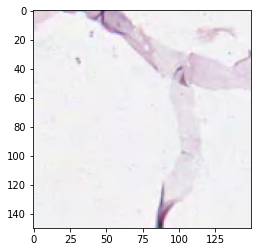

In [2]:
# EXTRACT

test_ds = tfds.load(name="colorectal_histology", 
                   split="train[0%:10%]",
                   shuffle_files=True,
                   as_supervised=True)

val_ds = tfds.load(name="colorectal_histology", 
                   split="train[10%:30%]",
                   shuffle_files=True,
                   as_supervised=True)

train_ds = tfds.load(name="colorectal_histology", 
                     split="train[-70%:]", 
                     shuffle_files=True, 
                     as_supervised=True)

for data in train_ds.take(1):
    image = data[0].numpy().squeeze()
    label = data[1].numpy()
    
    print("Label: {}".format(label))
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()


In [3]:
# Extract labels
tester = test_ds.take(1)
img_1 = []
lab_1 = 0
for example in tester:  
  img_1 = example[0]
  lab_1 = example[1]
img_1.shape
lab_1

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label


In [5]:
tds = train_ds.as_numpy_iterator()
labs = []
for el in tds:
  labs.append(el[1])

lab_cnt = []
for i in range(0,8):
  lab_cnt.append(labs.count(i))
lab_cnt
lab_list = ['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty']

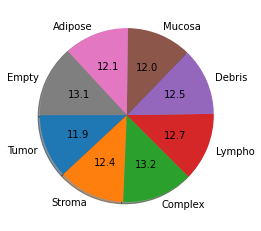

<Figure size 1152x1152 with 0 Axes>

In [6]:
plt.pie(lab_cnt, labels=['Tumor', 'Stroma','Complex', 'Lympho','Debris','Mucosa','Adipose','Empty'], startangle=180, 
        autopct='%1.1f', shadow=True)
plt.figure(figsize=(16,16))
plt.show()

In [7]:
test_lb = test_ds.as_numpy_iterator()
test_labels = []
for tlb in test_lb:
  test_labels.append(tlb[1])

#### Transform
Normalize the images to float32 between 0 - 1. Then shuffle, batch, cache and prefetch.

In [8]:
train_ds = train_ds.map(normalize_img,
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).batch(128).prefetch(tf.data.AUTOTUNE)

In [9]:
val_ds = val_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [10]:
test_ds = test_ds.map(normalize_img,
                    num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(128).cache().prefetch(tf.data.AUTOTUNE)

In [11]:
val_ds.enumerate()

<ZipDataset shapes: ((), ((None, 150, 150, 3), (None,))), types: (tf.int64, (tf.float32, tf.int64))>

### Model
We design a simple 2D Convolutional Neural Network to classify the textures.

In [12]:
kernel_size = (3,3)
pool_size= (2,2)
input_shape = (150,150,3)
## Model 3
#zeroth_filters = 16
#first_filters = 64
#second_filters = 256
#third_filters = 1024

## Model 4
zeroth_filters = 32
first_filters = 128
second_filters = 256
third_filters = 1024

dropout_conv = 0.3
dropout_dense = 0.3


model = tf.keras.models.Sequential([
                                    layers.Conv2D(zeroth_filters, kernel_size, padding='same',activation = 'relu', input_shape = input_shape),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(first_filters, kernel_size, activation = 'relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(second_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    layers.Conv2D(third_filters, kernel_size, activation ='relu'),
                                    layers.MaxPooling2D(pool_size = pool_size),
                                    
                                    layers.Flatten(),
                                    layers.Dense(512, activation = "relu"),
                                    layers.Dense(8, activation = "softmax")
                                    
])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 1024)      2

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


### Training

In [14]:
filepath = "model5.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_sparse_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(train_ds, 
                    validation_data=val_ds,
                    epochs=40, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


28/28 [==============================] - 31s 616ms/step - loss: 1.8673 - sparse_categorical_accuracy: 0.2883 - val_loss: 1.2417 - val_sparse_categorical_accuracy: 0.4360

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.43600, saving model to model5.h5
Epoch 2/40
28/28 [==============================] - 11s 374ms/step - loss: 1.0099 - sparse_categorical_accuracy: 0.5417 - val_loss: 0.9103 - val_sparse_categorical_accuracy: 0.6220

Epoch 00002: val_sparse_categorical_accuracy improved from 0.43600 to 0.62200, saving model to model5.h5
Epoch 3/40
28/28 [==============================] - 10s 375ms/step - loss: 0.9428 - sparse_categorical_accuracy: 0.5783 - val_loss: 0.8637 - val_sparse_categorical_accuracy: 0.6210

Epoch 00003: val_sparse_categorical_accuracy did not improve from 0.62200
Epoch 4/40
28/28 [==============================] - 10s 373ms/step - loss: 0.8127 - sparse_categorical_accuracy: 0.6617 - val_loss: 0.7692 - val_sparse_categorical_accuracy: 0.6420

Ep

### Evaluating the Model

In [15]:
val_loss, val_acc = model.evaluate(test_ds)

4/4 [==============================] - 5s 2s/step - loss: 0.4937 - sparse_categorical_accuracy: 0.8460


In [16]:
val_loss, val_acc

(0.493666410446167, 0.8460000157356262)

<Figure size 432x288 with 0 Axes>

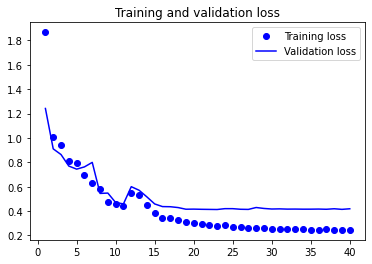

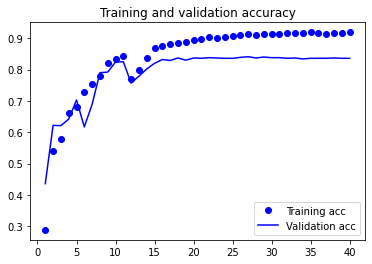

<Figure size 432x288 with 0 Axes>

In [17]:

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [18]:
predictions = model.predict(test_ds)

In [19]:
preds_ds = pd.DataFrame(predictions, columns=lab_list)
preds_ds.head()

,Tumor,Stroma,Complex,Lympho,Debris,Mucosa,Adipose,Empty
0,0.007869,8.070335e-02,1.638127e-01,2.470537e-03,5.463732e-02,6.905053e-01,1.719991e-06,3.184616e-12
1,0.000166,3.538494e-01,3.743397e-03,6.449260e-07,6.422403e-01,4.007711e-07,3.490596e-08,1.366083e-10
2,0.857866,2.625691e-09,3.799013e-02,1.106707e-02,2.777561e-05,9.304897e-02,6.368475e-11,4.683645e-15
3,0.999993,1.677848e-14,6.819470e-06,2.991934e-07,9.345283e-10,2.831999e-07,1.412498e-15,2.170046e-18
4,0.000008,2.228786e-05,8.110876e-07,1.768258e-10,4.066520e-03,4.643520e-08,9.955811e-01,3.210301e-04


#### Confusion Matrix

In [20]:
from sklearn.metrics import roc_auc_score

cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

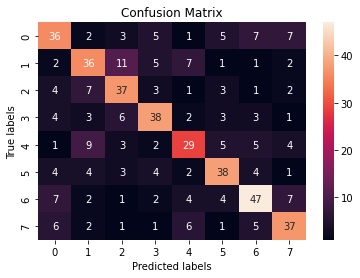

In [21]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

## Model explanation using Randomized Image Sampling for Explanations (RISE)
RISE is an approach for explaining a black-box model's predictions by estimating the importance of regions of the input image [5]. The model is probed using randomly masked versions of the input image and collecting the corresponding outputs. Code samples for RISE are available on a Github repo for the project https://github.com/eclique/RISE.git.

A summary of the RISE approach is illustrated by the equation
$
  S(\lambda)_{I,f} \approx^{MC} \frac{1}{\mathbb E[M] \cdot N } \sum_{i=1}^{N} f(I \odot M_{i}) \cdot M_{i}(\lambda)  
$

In [52]:
from keras.preprocessing import image

In [53]:
def load_img(path):
    img = image.load_img(path, target_size=input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #x = preprocess_input(x)
    return img, x

### Generating random masks

In [54]:
input_size = (150,150)
def generate_masks(N, s, p1):
    input_size = (150,150)
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks

In [55]:
batch_size = 100

def explain(model, inp, masks):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        #preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
        preds.append(model.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *input_size)
    sal = sal / N / p1
    pd = model.predict(inp)
    return sal, pd

In [56]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [57]:
N = 2000
s = 8
p1 = 0.5
masks = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:07<00:00, 274.20it/s]


### Explaining Disease Classifications

#### Lympho

In [71]:
img, x = load_img('/content/04Lympho.tif')

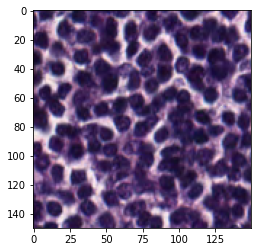

In [72]:
type(x)
plt.imshow(img)

In [73]:
sal, pdd = explain(model, x, masks)

Explaining: 100%|██████████| 20/20 [00:03<00:00,  5.05it/s]


In [74]:
pdd

array([[0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

In [77]:
top_k_values, top_k_indices = tf.nn.top_k(pdd, k=1)

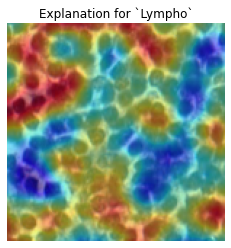

In [78]:
for top_k_index in top_k_indices[0]:
  plt.title('Explanation for `{}`'.format(lab_list[top_k_index]))
  plt.axis('off')
  plt.imshow(img)
  plt.imshow(sal[top_k_index], cmap='jet', alpha=0.5)
  # plt.colorbar()
  plt.show()
  #print(top_k_index)

In this way we can demonstrate classification of images for oncology applications.

#### Debris

In [85]:
img, x = load_img('/content/05Debris.tif')

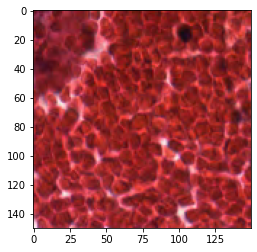

In [86]:
type(x)
plt.imshow(img)

In [87]:
sal, pdd = explain(model, x, masks)

Explaining: 100%|██████████| 20/20 [00:03<00:00,  5.07it/s]


In [88]:
pdd

array([[0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [89]:
top_k_values, top_k_indices = tf.nn.top_k(pdd, k=1)

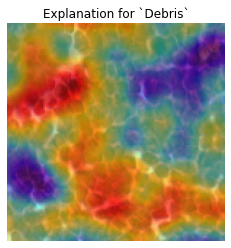

In [90]:
for top_k_index in top_k_indices[0]:
  plt.title('Explanation for `{}`'.format(lab_list[top_k_index]))
  plt.axis('off')
  plt.imshow(img)
  plt.imshow(sal[top_k_index], cmap='jet', alpha=0.5)
  # plt.colorbar()
  plt.show()
  #print(top_k_index)

In this way we can demonstrate classification of images for oncology applications.

### **References**
[1] https://www.rcpath.org/discover-pathology/news/fact-sheets/histopathology.html

[2] https://www.nationaldiagnostics.com/taxonomy/articles/histology/histology-fundamentals

[3] https://www.leicabiosystems.com/knowledge-pathway/an-introduction-to-routine-and-special-staining/

[4] Kather, J. N., Zöllner, F. G., Bianconi, F., Melchers, S. M., Schad, L. R., Gaiser, T., Weis, C.-A. (2016). Collection of textures in colorectal cancer histology [Data set]. Zenodo. http://doi.org/10.5281/zenodo.53169

[5] RISE: Randomized Input Sampling for Explanation of Black-box Models https://arxiv.org/abs/1806.07421